## Statistická práce

### Data
Pro práci byla použita data hráčů hry osu! z [data.ppy.sh](https://data.ppy.sh/), konkrétně data sesbíraná k 5.6.2024 obsahující top 1000 hráčů herního módu osu!.

Neboť jsou data ve formátu sql, tak jsem z něj vyextrahoval data do formátu csv pomocí přiloženého skriptu convert.py.

Z celkového datasetu jsem vybral 3 soubory, ze kterých jsem čerpal data pro další výpočty:
- `osu_user_stats` - Obsahuje data o jednotlivých hráčích, kteří jsou v top 1000 na žebříčku. Zahrnuje rozličná data, pro nás bude důležité hlavně jejich user_id, přesnost, celkové skóre a pozice.
- `osu_beatmap_failtimes` - První dva sloupce určují ID herní mapy (beatmapy) a typ ukončení hry (fail = hřáč na těchto míste prohrál; exit = hráč opustil herní mapu dobrovolně). Zbylé sloupce pak obsahují pouze počty ukončení hry na určité mapě v určitém procentu postupu.
- `osu_scores_high` - Obsahuje data o nejlepších výkonech (skóre) hráčů na určitých herních mapách. První tři sloupce obsahují ID skóre, mapy a hráče. Nás pak zajímá hlavně sloupec čtvrtý, který obsahuje vlastní hodnotu dosaženého skóre.

### Zkoumané problémy

V této práce jsem se rozhodl podívat na 3 různé problémy:
- Srovnání výkonu (skóre) dvou hráčů z předních míst žebříčku přes mapy obsažené v tomto datasetu. Pomocí párového t-testu pak zjistím, zdali hráči mají podobný výkon přes všechny herní mapy.
- Pokusit se z grafu odhadnout distribuci failtimes přes mapy v datasetu a zjistit, zdali jí doopravdy odpovídá pomocí chi-squared testu.
- Otestování hypotézy, že průměrná přesnost všech hráčů je 95% pomocí konfidenčního intervalu.

### Srovnání dvou hráčů

V této sekci porovnám dva hráče s podobným celkovým skóre z předních pozic žebříčku (konkrétně hráče na pozici #2 a #4 - oba mají okolo 50M celkového skóre).

Použiji zde data z `osu_scores_high`, kde dostanu skóre obou hráčů pro herní mapy, které hráli oba hráči. (Pozice a celkové skóre je pak obsaženo v `osu_user_stats`)

Dále pak využiji párového t-testu. Za nulovou hypotézu zvolím, že hráči mají stejný výkon přes všechny herní mapy. Alternativní hypotézou pak je, že hráč #4 má lepší výkon (celkové skóre má o trochu vyšší).

In [6]:
import csv
import pandas as pd
from scipy.stats import ttest_rel

# Dataset
file_path = '2024_06_05_performance_osu_top_1000\osu_scores_high.txt'

firstPlayerID = 9269034         # Player #2
secondPlayerID = 10549880       # Player #4

# Record maps that have a set score
firstMaps = []
secondMaps = []

# Store highest score for a player
firstScores = {}
secondScores = {}

# Read CSV file
with open(file_path, mode='r') as file:
    csv_reader = csv.reader(x.replace('\0', '') for x in file)
    
    # Iterate through the rows
    for row in csv_reader:
        # First player
        if int(row[2]) == firstPlayerID:
            firstMaps.append(int(row[1]))

            # store only highest score for a map
            if int(row[1]) in firstScores:
                if firstScores[int(row[1])] < int(row[3]):
                    firstScores[int(row[1])] = int(row[3])
            else:
                firstScores[int(row[1])] = int(row[3])

        # Second player
        elif int(row[2]) == secondPlayerID:
            secondMaps.append(int(row[1]))

            # store only highest score for a map
            if int(row[1]) in secondScores:
                if secondScores[int(row[1])] < int(row[3]):
                    secondScores[int(row[1])] = int(row[3])
            else:
                secondScores[int(row[1])] = int(row[3])

# Get maps that both players have set a score on
common_items = set(firstMaps) & set(secondMaps)

# Print the number of common maps
print("Number of beatmaps in common:", len(common_items))

# Total score counters
firstTotal = 0
secondTotal = 0

# Lists with only common scores
firstCommonScores = []
secondCommonScores = []

# Get only scores set on maps in common
for mapID in common_items:
    firstTotal += firstScores[mapID]
    firstCommonScores.append(firstScores[mapID])

    secondTotal += secondScores[mapID]
    secondCommonScores.append(secondScores[mapID])
    

print("First total score: " + str(firstTotal))
print("Second total score: " + str(secondTotal))


# Load the data
data = {
    "Player 2 score": firstCommonScores,
    "Player 4 score": secondCommonScores
}
df = pd.DataFrame(data)

# Paired t-test
t_stat, p_value = ttest_rel(df["Player 4 score"], df["Player 2 score"], alternative='greater')

# Print the results
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

# Determine if the null hypothesis was rejected
alpha = 0.05        # statistically significant
if p_value < alpha:
    print("Reject the null hypothesis: Player #4 performs much better than player #2.")
else:
    print("Fail to reject the null hypothesis: Player #4 does not perform much better than player #2.")

Number of beatmaps in common: 989
First total score: 18475191509
Second total score: 18749376937
t-statistic: 0.23051679690459942
p-value: 0.4088689672304645
Fail to reject the null hypothesis: Player #4 does not perform much better than player #2.


Protože je výsledná p-hodnota větší jak hranice 0.05, tak se nám nulovou hypotézu nepodařilo zamítnout, tedy 2. a 4. hráč mají podobný výkon přes všechny mapy. Toto odpovídá očekávanému výsledku, neboť mají podobné celkové skóre přes všechny mapy (50 404 563 684 a 52 092 765 043).

Můžeme dále za secondPlayerID dosadit ID hráče, který je na žebříčku první (7562902). Dostaneme porovnání mezi 2. a 1. hráčem:

>Number of common items: 1463  
First total score: 27972751828  
Second total score: 44874013912  
t-statistic: 12.054520254981117  
p-value: 2.849224475343422e-32  
Reject the null hypothesis: Player #1 performs much better than player #2. 


Zde je tedy naše nulová hypotéza zamítnuta a hráč #1 je mnohem lepší přes všechny herní mapy než hráč #2. Toto znovu odpovídá očekávanému výsledku, neboť hráč #1 má více jak dvojnásobné skóre přes všechny herní mapy (107 885 285 646) než hráč #2 (50 404 563 684).

### Distribuce failtimes

Tato část se zabývá odhadnutím distribuce failtimes (procentuální postup v herní mapě, kdy hráč prohrál) přes mnoho map a hráčů.

Z datového souboru `osu_beatmap_failtimes` můžeme vyčíst failtimes, pokud filtrujeme pouze data s hodnotou `fail` (místo `exit`).

Po zpracování (sečtení) failtimes přes všechny mapy v datasetu si můžeme zobrazit graf rozložení failtimes. Z něj jsem se pokusil odhadnout jejich rozdělení - vybral jsem logaritmicko-normální.

Dále použijeme chi-squared test pro otestování hypotézy, zdali data opravdu mají logaritmicko-normální rozdělení:

Most common fail percentage: 12
P-value: 0.0
Reject the null hypothesis: Data does not follow the Lognormal distribution.


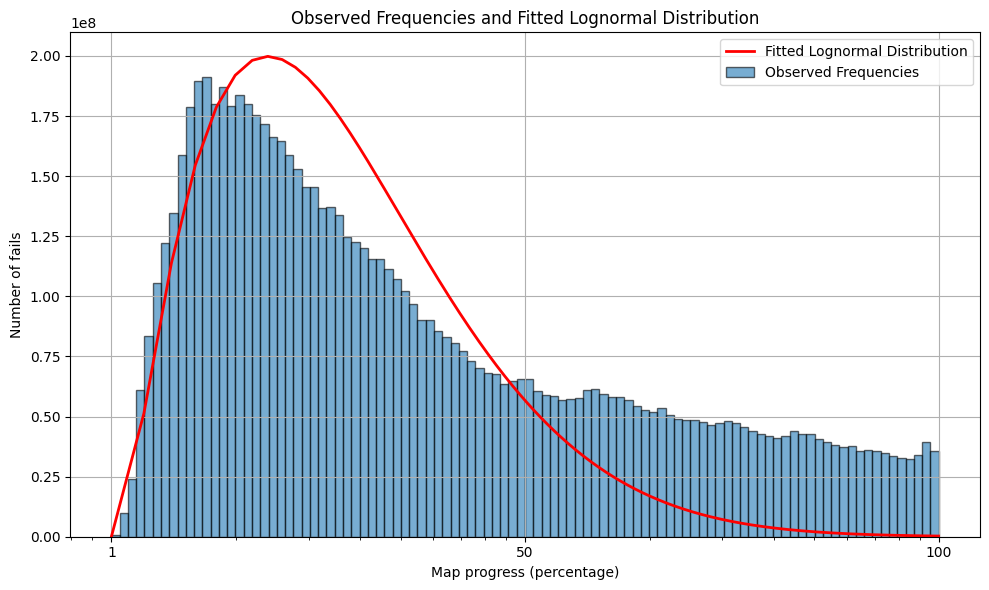

In [15]:
import csv
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Dataset
file_path_2 = '2024_06_05_performance_osu_top_1000\osu_beatmap_failtimes.txt'

# Counter array for all failtimes
fail_percentage = np.zeros(100)

with open(file_path_2, mode='r') as file:
    csv_reader = csv.reader(file)
    
    # Iterate through the rows
    for row in csv_reader:
        # Filter only failtimes
        if row[1] == "fail":
            fail_percentage += np.array(row[2:102], dtype=int)

# Get most common fail percentage across all maps in dataset
max_fail_perc = np.argmax(fail_percentage) + 1
print("Most common fail percentage: " + str(max_fail_perc))


fail_freq = fail_percentage

# Define bins for histogram
bins = np.logspace(0, 2, 101)

# Estimate parameters of the lognormal distribution
bin_centers = (bins[:-1] + bins[1:]) / 2

# Get sample mean and variance of the log-transformed bin centers, weighted by frequencies
log_bin_centers = np.log(bin_centers)

sample_mean_log = np.sum(log_bin_centers * fail_freq) / np.sum(fail_freq)
sample_var_log = np.sum(fail_freq * (log_bin_centers - sample_mean_log)**2) / np.sum(fail_freq)

# Estimate parameters of the normal distribution
sigma = np.sqrt(sample_var_log)     # Standard deviation
mu = sample_mean_log                # Mean

# Define the lognormal distribution from mu and sigma
shape = sigma
scale = np.exp(mu)

# Calculate the expected frequencies for each bin (for the fitted lognorm distribution)
expected_freq = stats.lognorm.pdf(bin_centers, shape, loc=1, scale=scale) * np.diff(bins) * np.sum(fail_freq)

# Normalize (to fix rounding error when passed to chisquare)
normalized_expected_freq = expected_freq * (np.sum(fail_freq) / np.sum(expected_freq))

# Perform the chi-square test
chi2_statistic, p_value = stats.chisquare(f_obs=fail_freq, f_exp=normalized_expected_freq)

print(f"P-value: {p_value}")

# Check if hypothesis was rejected
if p_value < 0.05:
    print("Reject the null hypothesis: Data does not follow the Lognormal distribution.")
else:
    print("Fail to reject the null hypothesis: Data may follow the Lognormal distribution.")


# Plot data agains lognormal plot
plt.figure(figsize=(10, 6))

# Observed frequencies as a bar plot
plt.bar(bins[:-1], fail_freq, width=np.diff(bins), align='edge', edgecolor='k', alpha=0.6, label='Observed Frequencies')

# Compute the PDF
x = np.linspace(min(bins), max(bins), 500)
pdf = stats.lognorm.pdf(x, shape, loc=1, scale=scale) 
pdf = pdf * (np.sum(fail_freq) / np.sum(pdf))


# Lognormal distribution as a line plot
plt.plot(x, pdf, 'r-', lw=2, label='Fitted Lognormal Distribution')

# Fix scale and label ticks correctly
plt.xscale('log')
positions = [1, 10, 100]
new_labels = ['1', '50', '100']
plt.xticks(positions, new_labels)

# Draw rest of the graph
plt.title('Observed Frequencies and Fitted Lognormal Distribution')
plt.xlabel('Map progress (percentage)')
plt.ylabel('Number of fails')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Rozložení míst, kde hráči nejčastěji prohrávají v herní mapě, tedy neodpovídá logaritmicko-normálnímu rozdělení. Toto odpovídá výslednému grafu, kde je vidět, že pro failtimes nad 50% postupu v herní mapě logaritmicko-normální distribuce odpovídá velmi špatně.

### Konfidenční interval přesnosti

U poslední úlohy se pokusím zjistit, zdali přesnost 95% (pro všechny hráče) leží v 95%-konfidenčním intevalu z přesností hráčů v datasetu. Přesnost 95% jsem zvolil jako nulovou hypotézu, neboť je to častá hodnota, kolem které se přesnost hráčů pohybuje.

Využiji zde data ze souboru `osu_user_stats`, který obsahuje údaje o přesnosti pro každého hráče.

Mean Accuracy: 0.944777422
95.0% Confidence Interval: (np.float64(0.9433021293680406), np.float64(0.9462527146319595))
Hypothesized mean (mu_0 = 0.95) is outside the confidence interval (0.9433021293680406, 0.9462527146319595).
Rejected the null hypothesis - the average accuracy is not 95%.


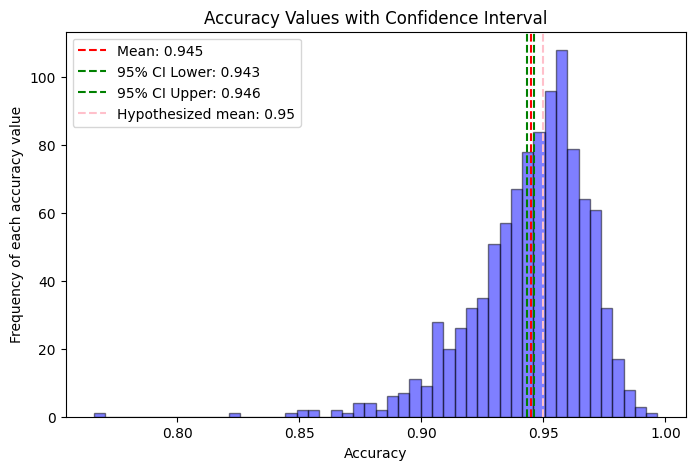

In [19]:
import csv
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Dataset
file_path = '2024_06_05_performance_osu_top_1000\osu_user_stats.txt'

# Counters for storing accuracy values of 1000 players
total = 0
count = 0
accuracy_values = np.zeros(1000)

# Read the CSV
with open(file_path, mode='r') as file:
    csv_reader = csv.reader(file)
    
    # Iterate through the rows and store accuracy values
    i = 0
    for row in csv_reader:
        acc = float(row[7])
        accuracy_values[i] = np.float64(acc)
        total += acc
        count += 1
        i += 1

# Parameters
confidence_level = 0.95  # 95% confidence interval

# Calculate mean and standard error
mean_accuracy = np.mean(accuracy_values)
sem = stats.sem(accuracy_values)  # Standard error
df = len(accuracy_values)-1     # degrees of freedom

mu_0 = 0.95 # Hypothesized mean for all players

# Calculate the confidence interval
confidence_interval = stats.t.interval(confidence_level, df, loc=mean_accuracy, scale=sem)

print(f"Mean Accuracy: {mean_accuracy}")
print(f"{confidence_level*100}% Confidence Interval: {confidence_interval}")

# Check if hypothesized mean is inside the interval
lower_bound, upper_bound = confidence_interval
if lower_bound <= mu_0 <= upper_bound:
    print(f"Hypothesized mean (mu_0 = {mu_0}) is inside the confidence interval ({lower_bound}, {upper_bound}).")
    print("Failed to reject the null hypothesis - the average accuracy is 95%.")
    
else:
    print(f"Hypothesized mean (mu_0 = {mu_0}) is outside the confidence interval ({lower_bound}, {upper_bound}).")
    print("Rejected the null hypothesis - the average accuracy is not 95%.")


# Plotting the accuracy values
plt.figure(figsize=(8, 5))
plt.hist(accuracy_values, bins=50, alpha=0.5, color='blue', edgecolor='black')

# Display mean, hypothesis and confidence interval
plt.axvline(mean_accuracy, color='red', linestyle='--', label=f'Mean: {mean_accuracy:.3f}')
plt.axvline(confidence_interval[0], color='green', linestyle='--', label=f'{confidence_level*100:.0f}% CI Lower: {confidence_interval[0]:.3f}')
plt.axvline(confidence_interval[1], color='green', linestyle='--', label=f'{confidence_level*100:.0f}% CI Upper: {confidence_interval[1]:.3f}')
plt.axvline(mu_0, color='pink', linestyle='--', label=f'Hypothesized mean: {mu_0:.2f}')

# Annotations and labels
plt.title('Accuracy Values with Confidence Interval')
plt.xlabel('Accuracy')
plt.ylabel('Frequency of each accuracy value')
plt.legend(loc='upper left')
plt.show()

Neboť naše nulová hypotéza (přesnost 95%) neleží v 95%-konfidenčním intervalu, tak ji můžeme zamítnout a tedy říci, že průměrná přesnost pro všechny hráče také není 95 procent. Tento výsledek je možný, neboť přesnost 95% byla pouze spekulovaná hodnota.

## Závěr

Za pomoci 3 různých příkladů výše se nám pro všechny hráče podařilo zjisit, že distribuce jejich failtimes neodpovídá logaritmicko-normální distribuci a že jejich průměrná přesnost není 95%. Pro dva hráče z předních pozic žebříčku jsme pak zjistili, že výkon #2 a #4 hráče není příliš rozdílný, avšak #1 hráč je výrazně lepší nežli #2 hráč.